<a href="https://colab.research.google.com/github/i-am-mel-dev/practicals/blob/master/DL101_part_1_OXML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 101 Tutorial for OxML 2020
### Prepared by Melvin Selim Atay
# Tutorial Objectives: 

*   Explore the main idea of artificial neural networks, deep feed-forward network
*   Get intuition of why it is necessary to build deep neural networks such as loss functions 
*   Learn and compute gradient descent using automatic differentiation. 
*   Familiarize with PyTorch.


   For convenience we will be using MNIST dataset throuhout this tutorial.











In [ ]:
#@title Setting Up Necessary Packages { vertical-output: true, display-mode: "form" }
import os
from __future__ import print_function, division

import itertools
#import time
from time import time
import numpy as np 

# PyTorch packages
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
# Plotting packages

import matplotlib.pyplot as plt

In [ ]:
#@title Setting torch transform
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
#@title Load Data (MNIST)
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 60000 # 

n_test_samples = 10000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

train_set = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, sampler=train_sampler)

test_set = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, sampler=test_sampler)

Extracting ..\input\MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ..\input\MNIST/MNIST/raw


Extracting ..\input\MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ..\input\MNIST/MNIST/raw


Extracting ..\input\MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ..\input\MNIST/MNIST/raw


Extracting ..\input\MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ..\input\MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#@title Enabling GPU
if torch.cuda.is_available():
  # Create tensors
  x = torch.ones(1000, 1000)
  y = 2 * x + 3
  # Do the calculation on cpu (default)
  # Matrix multiplication (for benchmark purpose)
  results = torch.mm(x, y)
  
  # Do the same calculation but on the gpu
  # First move tensors to gpu
  x = x.to("cuda")
  y = y.to("cuda")
  # Matrix multiplication (for benchmark purpose)
  results = torch.mm(x, y)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) is the dataset of handwritten digits, it has a training set of 60,000 examples and test set of 10,000 examples. 
![picture](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
##### https://en.wikipedia.org/wiki/MNIST_database#cite_note-10

torch.Size([64, 1, 28, 28])
torch.Size([64])


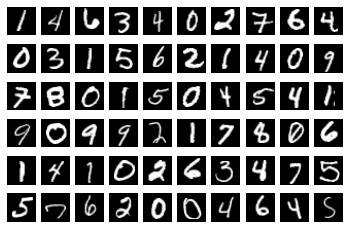

In [ ]:
#@title Loading and visualizing data
dataiter = iter(train_loader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')


# Deep artificial neural network implementation using *pytorch* 

We are building a feed forward neural network with two hidden layers.


Let $\mathbf{p}^{(n)} = \begin{bmatrix} p_1^{(n)} & p_2^{(n)} & \ldots & p_N^{(n)} \end{bmatrix}^T$ are pixel values of the input image of numbers. Here input image is 28x28 so we have 784 pixel values as an input per image in MNIST dataset.  The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{A}^{(0)} &= \mathbf{W}^{in} \mathbf{p}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], M = 784, N = 256\\
    \mathbf{A}^{(1)} &= \mathbf{W}^{(h_1)} \mathbf{A}^{(0)} + \mathbf{b}^{(h_1)},  && [\mathbf{W}^{(h_1)}: N \times R], N = 256, R = 128 \\
    \mathbf{A}^{(2)} &= \mathbf{W}^{(h_2)} \mathbf{A}^{(1)} + \mathbf{b}^{(h_2)},  && [\mathbf{W}^{(h_2)}: R \times S], R = 128, S = 64 \\
   y^{(n)} &= \mathbf{W}^{out} \mathbf{A}^{(2)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 10 \times S], 
\end{align}
where $y^{(n)}$ denotes the output of the network 


The $M$-dimensional vectors $\mathbf{A}^{(1)}$ and $\mathbf{A}^{(2)}$    denotes the activations of the **hidden layers** of the network. 


Parameters of the network are consists of the weights and biases $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{(h_1)}, \mathbf{b}^{(h_1)}, \mathbf{W}^{(h_2)}, \mathbf{b}^{(h_2)}, \mathbf{W}^{out}, \mathbf{b}^{out}$.

 Parameters of the network will be optimized by gradient descent.



![picture](https://i-am-mel-dev.github.io/images/ann.png)

If we do not add any activation functions,  that the deep network we constructed above comprises solely **linear** operations on each layer: each layer is just a weighted sum of the elements in the previous layer. It turns out that linear hidden layers like this are not particularly useful, since a sequence of linear transformations is actually essentially the same as a single linear transformation. 
In other words, the output is still just a weighted sum of elements in the input -- the hidden layer has done nothing to change this.

To extend the set of computable input/output transformations to more than just weighted sums, we'll incorporate a **non-linear activation function** in the hidden units. This is done by simply modifying the equation for the hidden layer activations to be
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is referred to as the activation function. Using a non-linear activation function will ensure that the hidden layer performs a non-linear transformation of the input, which will make our network much more powerful. In practice, deep networks *always* use non-linear activation functions.


**Re**ctified **L**inear **U**nits", or **ReLU**'s
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}



## There are three ways of implementing neural networks in PyTorch:

    nn.Module
    nn.Sequential
    nn.ModuleList

### `nn.Module`

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_unit1, n_unit2, n_unit3, n_output):
        super().__init__()
        
        # Inputs to 1st hidden layer linear transformation 
        self.hidden1 = nn.Linear(n_inputs, n_unit1) # 1 layer:- input numbers, hidden unit numbers 
        
        self.relu = nn.ReLU() # Defining Rectified linear unit as activation

        self.hidden2 =  nn.Linear(n_unit1, n_unit2) #2 layer:- hidden layer 
        
        self.tanh = nn.Tanh()
        self.hidden3 =  nn.Linear(n_unit2, n_unit3) #3 layer:- hidden layer 
        
        self.tanh2 = nn.Tanh()

        # Output layer 
        self.output = nn.Linear(n_unit3, n_output) # output layer
        self.softmax = nn.LogSoftmax(dim=1) # softmax

        
    def forward(self, x):
        x = self.hidden1(x) 
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.tanh2(x)
        x = self.hidden3(x)
        x = self.tanh2(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [ ]:
model = NeuralNetwork(n_inputs=784, n_unit1=256, n_unit2=128, n_unit3= 64, n_output=10)
model

NeuralNetwork(
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (tanh): Tanh()
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (tanh2): Tanh()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### `nn.ModuleList`

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_unit1, n_unit2, n_unit3, n_output):
        super().__init__()
        l1 = nn.Linear(n_inputs, n_unit1)
        a1 = nn.ReLU()
        l2 = nn.Linear(n_unit1, n_unit2)
        a2 = nn.Tanh()
        l3 = nn.Linear(n_unit2, n_unit3)
        a3 = nn.Tanh()
        l4 = nn.Linear(n_unit3, n_output)
        s = nn.LogSoftmax(dim=1)
        
        l = [l1, a1, l2, a2, l3, a3, l4, s]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

In [ ]:
model = NeuralNetwork(n_inputs=784, n_unit1=256, n_unit2= 128, n_unit3 = 64, n_output=10)
model

NeuralNetwork(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

### `nn.Sequential`

In [ ]:
# Model creation with neural net Sequential model
model=nn.Sequential(nn.Linear(784,256), # 1 Layer:- 784 input 256 output
                    nn.ReLU(),          
                    nn.Linear(256,128),  # 2 Layer:- 256 Input and 128 output
                    nn.Tanh(),
                    nn.Linear(128,64),  # 3 Layer:- 128 Input and 64 output
                    nn.Tanh(),           
                    nn.Linear(64,10),   # 3 Layer:- 64 Input and 10 output
                    nn.LogSoftmax(dim=1) # Defining the softmax to find the probablities for the last output 
                  ) 

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


We are using negative log likelihood loss and log softmax for classification task. 

![picture](https://miro.medium.com/max/700/1*z5zL8kz7TPW1y3okAjuvBA.jpeg)

These functions are also implemented in  `torch.nn.CrossEntropyLoss`

In [ ]:
# defining the negative log-likelihood loss for calculating loss
criterion = nn.NLLLoss() 

In [ ]:
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL-loss

We are using stochastic gradient descent for optimization.
Mathematically, Gradient Descent is a convex function whose output is the partial derivative of a set of parameters of its inputs. The greater the gradient, the steeper the slope.

Starting from an initial value, Gradient Descent is run iteratively to find the optimal values of the parameters to find the minimum possible value of the given cost function.

The word ‘stochastic‘ means a system or a process that is linked with a random probability. Hence, in Stochastic Gradient Descent, a few samples are selected randomly instead of the whole data set for each iteration. 

![picture](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/0e39e950-dd75-4c2f-a4ea-aa1ccd1eb8ca.png)

In [ ]:
# defining the optimiser with stochastic gradient descent and default parameters
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print('Initial weights - ', model[0].weight)

images, labels = next(iter(train_loader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass
output = model(images)
loss = criterion(output, labels)
# the backward pass and update weights
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0240,  0.0208,  0.0216,  ...,  0.0251,  0.0122, -0.0042],
        [-0.0312, -0.0232,  0.0135,  ..., -0.0259,  0.0095,  0.0138],
        [-0.0053,  0.0070,  0.0048,  ...,  0.0130,  0.0272, -0.0255],
        ...,
        [ 0.0095,  0.0114, -0.0169,  ...,  0.0269,  0.0131, -0.0071],
        [-0.0088, -0.0345, -0.0297,  ..., -0.0250,  0.0278,  0.0110],
        [-0.0046,  0.0034,  0.0346,  ..., -0.0338,  0.0230, -0.0308]],
       requires_grad=True)
Gradient - tensor([[-6.9222e-05, -6.9222e-05, -6.9222e-05,  ..., -6.9222e-05,
         -6.9222e-05, -6.9222e-05],
        [ 7.1292e-04,  7.1292e-04,  7.1292e-04,  ...,  7.1292e-04,
          7.1292e-04,  7.1292e-04],
        [-7.4909e-04, -7.4909e-04, -7.4909e-04,  ..., -7.4909e-04,
         -7.4909e-04, -7.4909e-04],
        ...,
        [-4.3261e-04, -4.3261e-04, -4.3261e-04,  ..., -4.3261e-04,
         -4.3261e-04, -4.3261e-04],
        [ 2.4486e-04,  2.4486e-04,  2.4486e-04,  ...,  2.4486e

In [ ]:
time0 = time()
epochs = 20 # total number of iteration for training
running_loss_list= []
epochs_list = []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatenning MNIST images with size [64,784]
        images = images.view(images.shape[0], -1) 
    
        # defining gradient in each epoch as 0
        optimizer.zero_grad()
        
        # modeling for each image batch
        output = model(images)
        
        # calculating the loss
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        # calculating the loss
        running_loss += loss.item()
        
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.4466558409008835
Epoch 1 - Training loss: 0.16354922025696808
Epoch 2 - Training loss: 0.11872489901501805
Epoch 3 - Training loss: 0.09050703096463641
Epoch 4 - Training loss: 0.07419387554414253
Epoch 5 - Training loss: 0.0645542273410598
Epoch 6 - Training loss: 0.055938178674255344
Epoch 7 - Training loss: 0.04741653123610357
Epoch 8 - Training loss: 0.04025967942135258
Epoch 9 - Training loss: 0.0359757254201758
Epoch 10 - Training loss: 0.03156802225557626
Epoch 11 - Training loss: 0.02620987076606941
Epoch 12 - Training loss: 0.022084646030087897
Epoch 13 - Training loss: 0.018982726537787827
Epoch 14 - Training loss: 0.01635531298944658
Epoch 15 - Training loss: 0.014724115621850097
Epoch 16 - Training loss: 0.011598301877422548
Epoch 17 - Training loss: 0.015730660112313694
Epoch 18 - Training loss: 0.009772086125975505
Epoch 19 - Training loss: 0.008518094640423251

Training Time (in minutes) = 3.1759554227193196


In [ ]:
#@title Classification predictions plot
def classify(img, ps):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### Predictions: 
Predictions below shows the output of log probabilities and predicted class of any random image from test set.

Predicted Digit = 3


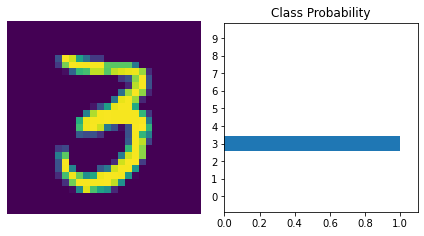

In [ ]:
images, labels = next(iter(test_loader))
# replace trainloader to check training accuracy.

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logpb = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
pb = torch.exp(logpb)
probab = list(pb.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
classify(img.view(1, 28, 28), pb)

### Testing and test results: 
Finally we are calculating testing accuracy of our neural network.

In [ ]:
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)

    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))
    

Number Of Images Tested = 10000

Model Accuracy = 0.9813


### How to save a model:

In [ ]:
torch.save(model, 'nn_model_mnist.pth') # .pt or .pth extension

Adapted from Neuromatch [DL Tutorial](https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W3D4_DeepLearning1), [h1ros](h1ros.github.io) and [pytorch](https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ)